# Sparsely-Gated Mixture-of-Experts Layers

See "Outrageously Large Neural Networks"
https://arxiv.org/abs/1701.06538

Author: David Rau

The code is based on the TensorFlow implementation:

https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/utils/expert_utils.py

# dependencies


In [4]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model

In [5]:
class SparseDispatcher(object):
    """Helper for implementing a mixture of experts.
    The purpose of this class is to create input minibatches for the
    experts and to combine the results of the experts to form a unified
    output tensor.
    There are two functions:
    dispatch - take an input Tensor and create input Tensors for each expert.
    combine - take output Tensors from each expert and form a combined output
      Tensor.  Outputs from different experts for the same batch element are
      summed together, weighted by the provided "gates".
    The class is initialized with a "gates" Tensor, which specifies which
    batch elements go to which experts, and the weights to use when combining
    the outputs.  Batch element b is sent to expert e iff gates[b, e] != 0.
    The inputs and outputs are all two-dimensional [batch, depth].
    Caller is responsible for collapsing additional dimensions prior to
    calling this class and reshaping the output to the original shape.
    See common_layers.reshape_like().
    Example use:
    gates: a float32 `Tensor` with shape `[batch_size, num_experts]`
    inputs: a float32 `Tensor` with shape `[batch_size, input_size]`
    experts: a list of length `num_experts` containing sub-networks.
    dispatcher = SparseDispatcher(num_experts, gates)
    expert_inputs = dispatcher.dispatch(inputs)
    expert_outputs = [experts[i](expert_inputs[i]) for i in range(num_experts)]
    outputs = dispatcher.combine(expert_outputs)
    The preceding code sets the output for a particular example b to:
    output[b] = Sum_i(gates[b, i] * experts[i](inputs[b]))
    This class takes advantage of sparsity in the gate matrix by including in the
    `Tensor`s for expert i only the batch elements for which `gates[b, i] > 0`.
    """

    def __init__(self, num_experts, gates):
        """Create a SparseDispatcher."""

        self._gates = gates
        self._num_experts = num_experts
        # sort experts
        sorted_experts, index_sorted_experts = torch.nonzero(gates).sort(0)
        # drop indices
        _, self._expert_index = sorted_experts.split(1, dim=1)
        # get according batch index for each expert
        self._batch_index = torch.nonzero(gates)[index_sorted_experts[:, 1], 0]
        # calculate num samples that each expert gets
        self._part_sizes = (gates > 0).sum(0).tolist()
        # expand gates to match with self._batch_index
        gates_exp = gates[self._batch_index.flatten()]
        self._nonzero_gates = torch.gather(gates_exp, 1, self._expert_index)

    def dispatch(self, inp):
        """Create one input Tensor for each expert.
        The `Tensor` for a expert `i` contains the slices of `inp` corresponding
        to the batch elements `b` where `gates[b, i] > 0`.
        Args:
          inp: a `Tensor` of shape "[batch_size, <extra_input_dims>]`
        Returns:
          a list of `num_experts` `Tensor`s with shapes
            `[expert_batch_size_i, <extra_input_dims>]`.
        """

        # assigns samples to experts whose gate is nonzero

        # expand according to batch index so we can just split by _part_sizes
        inp_exp = inp[self._batch_index].squeeze(1)
        return torch.split(inp_exp, self._part_sizes, dim=0)

    def combine(self, expert_out, multiply_by_gates=True):
        """Sum together the expert output, weighted by the gates.
        The slice corresponding to a particular batch element `b` is computed
        as the sum over all experts `i` of the expert output, weighted by the
        corresponding gate values.  If `multiply_by_gates` is set to False, the
        gate values are ignored.
        Args:
          expert_out: a list of `num_experts` `Tensor`s, each with shape
            `[expert_batch_size_i, <extra_output_dims>]`.
          multiply_by_gates: a boolean
        Returns:
          a `Tensor` with shape `[batch_size, <extra_output_dims>]`.
        """
        # apply exp to expert outputs, so we are not longer in log space
        stitched = torch.cat(expert_out, 0)

        if multiply_by_gates:
            stitched = stitched.mul(self._nonzero_gates)
        zeros = torch.zeros(self._gates.size(0), expert_out[-1].size(1), requires_grad=True, device=stitched.device)
        # combine samples that have been processed by the same k experts
        combined = zeros.index_add(0, self._batch_index, stitched.float())
        return combined

    def expert_to_gates(self):
        """Gate values corresponding to the examples in the per-expert `Tensor`s.
        Returns:
          a list of `num_experts` one-dimensional `Tensor`s with type `tf.float32`
              and shapes `[expert_batch_size_i]`
        """
        # split nonzero gates for each expert
        return torch.split(self._nonzero_gates, self._part_sizes, dim=0)

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.soft = nn.Softmax(1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.soft(out)
        return out


class MoE(nn.Module):

    """Call a Sparsely gated mixture of experts layer with 1-layer Feed-Forward networks as experts.
    Args:
    input_size: integer - size of the input
    output_size: integer - size of the input
    num_experts: an integer - number of experts
    hidden_size: an integer - hidden size of the experts
    noisy_gating: a boolean
    k: an integer - how many experts to use for each batch element
    """

    def __init__(self, input_size, output_size, num_experts, hidden_size, noisy_gating=True, k=4):
        super(MoE, self).__init__()
        self.noisy_gating = noisy_gating
        self.num_experts = num_experts
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.k = k
        # instantiate experts
        self.experts = nn.ModuleList([MLP(self.input_size, self.output_size, self.hidden_size) for i in range(self.num_experts)])
        self.w_gate = nn.Parameter(torch.zeros(input_size, num_experts), requires_grad=True)
        self.w_noise = nn.Parameter(torch.zeros(input_size, num_experts), requires_grad=True)

        self.softplus = nn.Softplus()
        self.softmax = nn.Softmax(1)
        self.register_buffer("mean", torch.tensor([0.0]))
        self.register_buffer("std", torch.tensor([1.0]))
        assert(self.k <= self.num_experts)

    def cv_squared(self, x):
        """The squared coefficient of variation of a sample.
        Useful as a loss to encourage a positive distribution to be more uniform.
        Epsilons added for numerical stability.
        Returns 0 for an empty Tensor.
        Args:
        x: a `Tensor`.
        Returns:
        a `Scalar`.
        """
        eps = 1e-10
        # if only num_experts = 1

        if x.shape[0] == 1:
            return torch.tensor([0], device=x.device, dtype=x.dtype)
        return x.float().var() / (x.float().mean()**2 + eps)

    def _gates_to_load(self, gates):
        """Compute the true load per expert, given the gates.
        The load is the number of examples for which the corresponding gate is >0.
        Args:
        gates: a `Tensor` of shape [batch_size, n]
        Returns:
        a float32 `Tensor` of shape [n]
        """
        return (gates > 0).sum(0)

    def _prob_in_top_k(self, clean_values, noisy_values, noise_stddev, noisy_top_values):
        """Helper function to NoisyTopKGating.
        Computes the probability that value is in top k, given different random noise.
        This gives us a way of backpropagating from a loss that balances the number
        of times each expert is in the top k experts per example.
        In the case of no noise, pass in None for noise_stddev, and the result will
        not be differentiable.
        Args:
        clean_values: a `Tensor` of shape [batch, n].
        noisy_values: a `Tensor` of shape [batch, n].  Equal to clean values plus
          normally distributed noise with standard deviation noise_stddev.
        noise_stddev: a `Tensor` of shape [batch, n], or None
        noisy_top_values: a `Tensor` of shape [batch, m].
           "values" Output of tf.top_k(noisy_top_values, m).  m >= k+1
        Returns:
        a `Tensor` of shape [batch, n].
        """
        batch = clean_values.size(0)
        m = noisy_top_values.size(1)
        top_values_flat = noisy_top_values.flatten()

        threshold_positions_if_in = torch.arange(batch, device=clean_values.device) * m + self.k
        threshold_if_in = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_in), 1)
        is_in = torch.gt(noisy_values, threshold_if_in)
        threshold_positions_if_out = threshold_positions_if_in - 1
        threshold_if_out = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_out), 1)
        # is each value currently in the top k.
        normal = Normal(self.mean, self.std)
        prob_if_in = normal.cdf((clean_values - threshold_if_in)/noise_stddev)
        prob_if_out = normal.cdf((clean_values - threshold_if_out)/noise_stddev)
        prob = torch.where(is_in, prob_if_in, prob_if_out)
        return prob

    def noisy_top_k_gating(self, x, train, noise_epsilon=1e-2):
        """Noisy top-k gating.
          See paper: https://arxiv.org/abs/1701.06538.
          Args:
            x: input Tensor with shape [batch_size, input_size]
            train: a boolean - we only add noise at training time.
            noise_epsilon: a float
          Returns:
            gates: a Tensor with shape [batch_size, num_experts]
            load: a Tensor with shape [num_experts]
        """
        clean_logits = x @ self.w_gate
        if self.noisy_gating and train:
            raw_noise_stddev = x @ self.w_noise
            noise_stddev = ((self.softplus(raw_noise_stddev) + noise_epsilon))
            noisy_logits = clean_logits + (torch.randn_like(clean_logits) * noise_stddev)
            logits = noisy_logits
        else:
            logits = clean_logits

        # calculate topk + 1 that will be needed for the noisy gates
        logits = self.softmax(logits)
        top_logits, top_indices = logits.topk(min(self.k + 1, self.num_experts), dim=1)
        top_k_logits = top_logits[:, :self.k]
        top_k_indices = top_indices[:, :self.k]
        top_k_gates = top_k_logits / (top_k_logits.sum(1, keepdim=True) + 1e-6)  # normalization

        zeros = torch.zeros_like(logits, requires_grad=True)
        gates = zeros.scatter(1, top_k_indices, top_k_gates)

        if self.noisy_gating and self.k < self.num_experts and train:
            load = (self._prob_in_top_k(clean_logits, noisy_logits, noise_stddev, top_logits)).sum(0)
        else:
            load = self._gates_to_load(gates)
        return gates, load

    def forward(self, x, loss_coef=1e-2):
        """Args:
        x: tensor shape [batch_size, input_size]
        train: a boolean scalar.
        loss_coef: a scalar - multiplier on load-balancing losses

        Returns:
        y: a tensor with shape [batch_size, output_size].
        extra_training_loss: a scalar.  This should be added into the overall
        training loss of the model.  The backpropagation of this loss
        encourages all experts to be approximately equally used across a batch.
        """
        gates, load = self.noisy_top_k_gating(x, self.training)
        # calculate importance loss
        importance = gates.sum(0)
        #
        loss = self.cv_squared(importance) + self.cv_squared(load)
        loss *= loss_coef

        dispatcher = SparseDispatcher(self.num_experts, gates)
        expert_inputs = dispatcher.dispatch(x)
        gates = dispatcher.expert_to_gates()
        expert_outputs = [self.experts[i](expert_inputs[i]) for i in range(self.num_experts)]
        y = dispatcher.combine(expert_outputs)
        return y, loss

# Train and evaluate

Starting training...

Epoch 1/100 | Train Loss: 1.1158 | Val Loss: 1.0973 | 
Epoch 2/100 | Train Loss: 1.0970 | Val Loss: 1.0820 | 
Epoch 3/100 | Train Loss: 1.0799 | Val Loss: 1.0652 | 
Epoch 4/100 | Train Loss: 1.0611 | Val Loss: 1.0476 | 
Epoch 5/100 | Train Loss: 1.0414 | Val Loss: 1.0295 | 
Epoch 6/100 | Train Loss: 1.0210 | Val Loss: 1.0109 | 
Epoch 7/100 | Train Loss: 1.0000 | Val Loss: 0.9917 | 
Epoch 8/100 | Train Loss: 0.9788 | Val Loss: 0.9722 | 
Epoch 9/100 | Train Loss: 0.9576 | Val Loss: 0.9527 | 
Epoch 10/100 | Train Loss: 0.9363 | Val Loss: 0.9335 | 
Epoch 11/100 | Train Loss: 0.9154 | Val Loss: 0.9148 | 
Epoch 12/100 | Train Loss: 0.8951 | Val Loss: 0.8968 | 
Epoch 13/100 | Train Loss: 0.8755 | Val Loss: 0.8799 | 
Epoch 14/100 | Train Loss: 0.8570 | Val Loss: 0.8616 | 
Epoch 15/100 | Train Loss: 0.8397 | Val Loss: 0.8470 | 
Epoch 16/100 | Train Loss: 0.8235 | Val Loss: 0.8339 | 
Epoch 17/100 | Train Loss: 0.8097 | Val Loss: 0.8234 | 
Epoch 18/100 | Train Loss: 0.7965 |

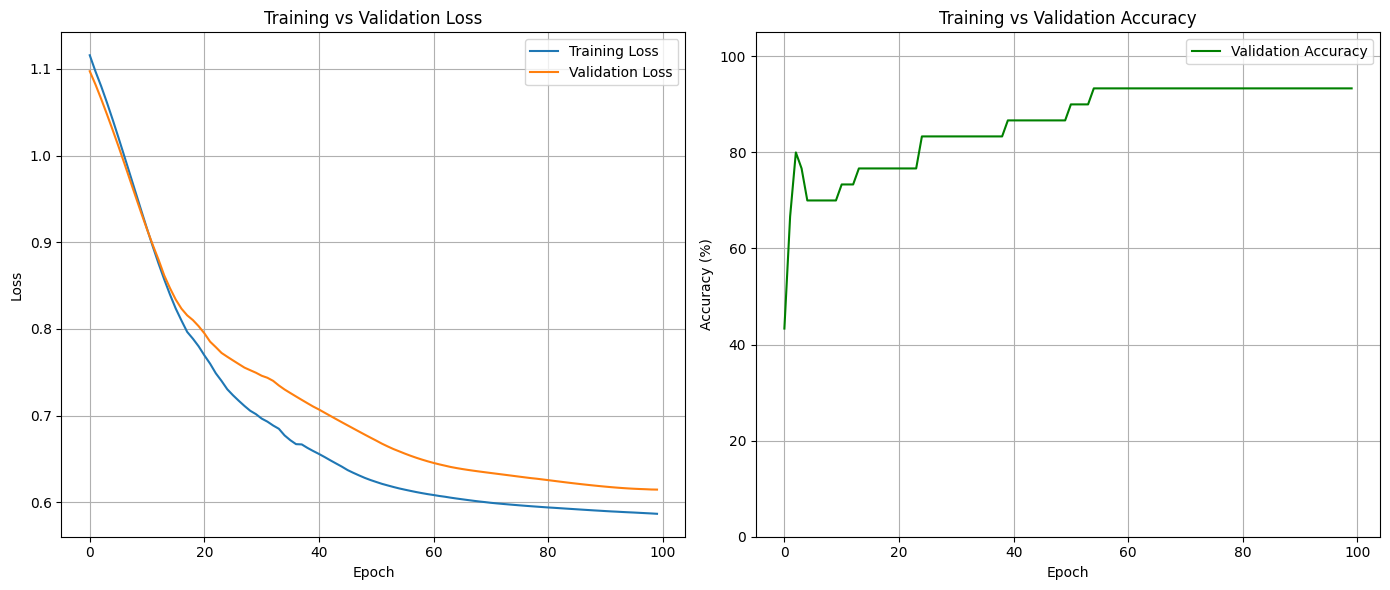

In [11]:
# 1. Load and Prepare the Iris Dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target

# Split data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert data to PyTorch Tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# 2. Define Model Hyperparameters
input_size = X_train.shape[1]
output_size = len(iris.target_names)
num_experts = 3
hidden_size = 16 
lr = 0.01
epochs = 100
top_k_gating=2

# 3. Instantiate the Model, Loss, and Optimizer
model = MoE(
    input_size=input_size,
    output_size=output_size,
    num_experts=num_experts,
    hidden_size=hidden_size,
    noisy_gating=False,
    k=top_k_gating
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# MODIFICATION: Lists for graphs, including accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 4. Training Loop
print("Starting training...\n")
for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred_train, aux_loss_train = model(X_train_tensor)
    
    # Calculate loss
    loss_train = criterion(y_pred_train, y_train_tensor)
    total_loss_train = loss_train + aux_loss_train
    
    # MODIFICATION: Calculate training accuracy
    _, predicted_train = torch.max(y_pred_train, 1)
    correct_train = (predicted_train == y_train_tensor).sum().item()
    accuracy_train = correct_train / y_train_tensor.size(0)
    
    # Backward pass and optimization
    total_loss_train.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        y_pred_val, aux_loss_val = model(X_val_tensor)
        loss_val = criterion(y_pred_val, y_val_tensor)
        total_loss_val = loss_val + aux_loss_val
        
        # MODIFICATION: Calculate validation accuracy
        _, predicted_val = torch.max(y_pred_val, 1)
        correct_val = (predicted_val == y_val_tensor).sum().item()
        accuracy_val = correct_val / y_val_tensor.size(0)

    # MODIFICATION: Updated print statement
    print(
        f"Epoch {epoch+1}/{epochs} | "
        f"Train Loss: {total_loss_train.item():.4f} | "
        f"Val Loss: {total_loss_val.item():.4f} | "
        #f"Train Acc: {accuracy_train*100:.2f}% | "
        #f"Val Acc: {accuracy_val*100:.2f}%"
    )
    
    # Append values to lists for plotting
    train_losses.append(total_loss_train.item())
    val_losses.append(total_loss_val.item())
    train_accuracies.append(accuracy_train)
    val_accuracies.append(accuracy_val)
    
# 5. Final Evaluation on Test Set
print("\nTraining finished. Evaluating on test data...")
model.eval()
with torch.no_grad():
    y_pred_test, _ = model(X_test_tensor)
    _, predicted_labels = torch.max(y_pred_test, 1)
    
    correct_predictions = (predicted_labels == y_test_tensor).sum().item()
    accuracy = correct_predictions / y_test_tensor.size(0)

print(f"\nFinal Test Accuracy: {accuracy * 100:.2f}%")

# MODIFICATION: Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot([acc * 100 for acc in val_accuracies], label='Validation Accuracy', color="green")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 105) # Set y-axis limit for accuracy

plt.tight_layout()
plt.show()